# Module 6 : Web search

## Show the evidence that you have be able to follow (codes and running results) the walkthrough
(1) Develop a simple web crawler (pg 33-38)

(2) Indexing using Solr (pg 43-48)

(3) Indexing using Elasticsearch (pg 52-55)

(4) Calculate the Pagerank score (pg 70-74)

(4) Boost the ranking score using the Pagerank for both Solr and Elasticsearch (pg 75-77)

# Preparing the library

In [1]:
import os

import pysolr
import requests
import multiprocessing
import pickle
import json
from bs4 import BeautifulSoup
from bs4.element import Comment
from queue import Queue, Empty
from concurrent.futures import ThreadPoolExecutor
from urllib.parse import urlparse, urljoin
from pathlib import Path

from elasticsearch import Elasticsearch

## 1 Simple Web Crawler

In [2]:
class MultiThreadCrawler:
    def __init__(self, base_url, depth):
        self.base_url = base_url
        extracted_url = urlparse(base_url)
        parent = extracted_url.path[:extracted_url.path.rfind("/") + 1]
        self.root_url = '{}://{}{}'.format(extracted_url.scheme, extracted_url.netloc, parent)
        self.pool = ThreadPoolExecutor(max_workers=multiprocessing.cpu_count() - 1)
        self.to_crawl = Queue()
        self.to_crawl.put({self.base_url: depth})
        self.stored_folder = Path("E:/CMU/953/IR481/Module6").parent / '../crawled/'

        if not Path(self.stored_folder).exists():
            Path.mkdir(self.stored_folder)
            
        if Path(self.stored_folder / 'url_list.pickle').exists():
            with open(self.stored_folder / 'url_list.pickle', 'rb') as f:
                self.crawled_pages = pickle.load(f)
            print(self.crawled_pages)
        else:
            self.crawled_pages = set([])
            
    def run_scraper(self):
        while True:
            try:
                target = self.to_crawl.get(timeout=10)
                url, depth = [(k, target[k]) for k in target][0]
                if url not in self.crawled_pages:
                    self.crawled_pages.add(url)
                    job = self.pool.submit(self.get_page, url, depth - 1)
                    job.add_done_callback(self.extract_page)
            except Empty:
                with open(self.stored_folder / 'url_list.pickle', 'wb') as f:
                    pickle.dump(self.crawled_pages, f, pickle.HIGHEST_PROTOCOL)
                with open(self.stored_folder / 'url_list.pickle', 'rb') as f:
                    print(pickle.load(f))
                break
            except Exception as e:
                print(e)
                continue
                
    def extract_page(self, obj):
        if obj.result():
            result, url, depth = obj.result()
            if result and result.status_code == 200:
                url_lists = self.parse_links(result.text, depth)
                self.parse_contents(url, result.text, url_lists)
                
    def get_page(self, url, depth):
        try:
            res = requests.get(url, timeout=(3, 30))
            return res, url, depth
        except requests.RequestException:
            return
        
    def parse_links(self, html, depth):
        soup = BeautifulSoup(html, 'html.parser')
        links = soup.find_all('a', href=True)
        url_lists = []
        for link in links:
            url = link['href']
            url = urljoin(self.root_url, url)
            if depth >= 0 and '..' not in url and url not in self.crawled_pages:
                print("Adding {}".format(url))
                self.to_crawl.put({url: depth})
            url_lists.append(url)
        return url_lists
    
    def parse_contents(self, url, html, url_lists):
        def tag_visible(element):
            if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]']:
                return False
            if isinstance(element, Comment):
                return False
            return True

        try:
            soup = BeautifulSoup(html, 'html.parser')
            texts = soup.findAll(text=True)
            visible_texts = filter(tag_visible, texts)
            title = soup.find('title').string.strip()
            text = u" ".join(t.strip() for t in visible_texts).strip()
            with open(self.stored_folder / (str(hash(url)) + '.txt'), 'w', encoding='utf-8') as f:
                json.dump({'url': url, 'title': title, 'text': text, 'url_lists': url_lists}, f, ensure_ascii=False)
        except:
            pass

In [3]:
s = MultiThreadCrawler("https://camt.cmu.ac.th/index.php/en/", 1)
s.run_scraper()

{'https://camt.cmu.ac.th/index.php/en/'}
{'https://camt.cmu.ac.th/index.php/en/'}


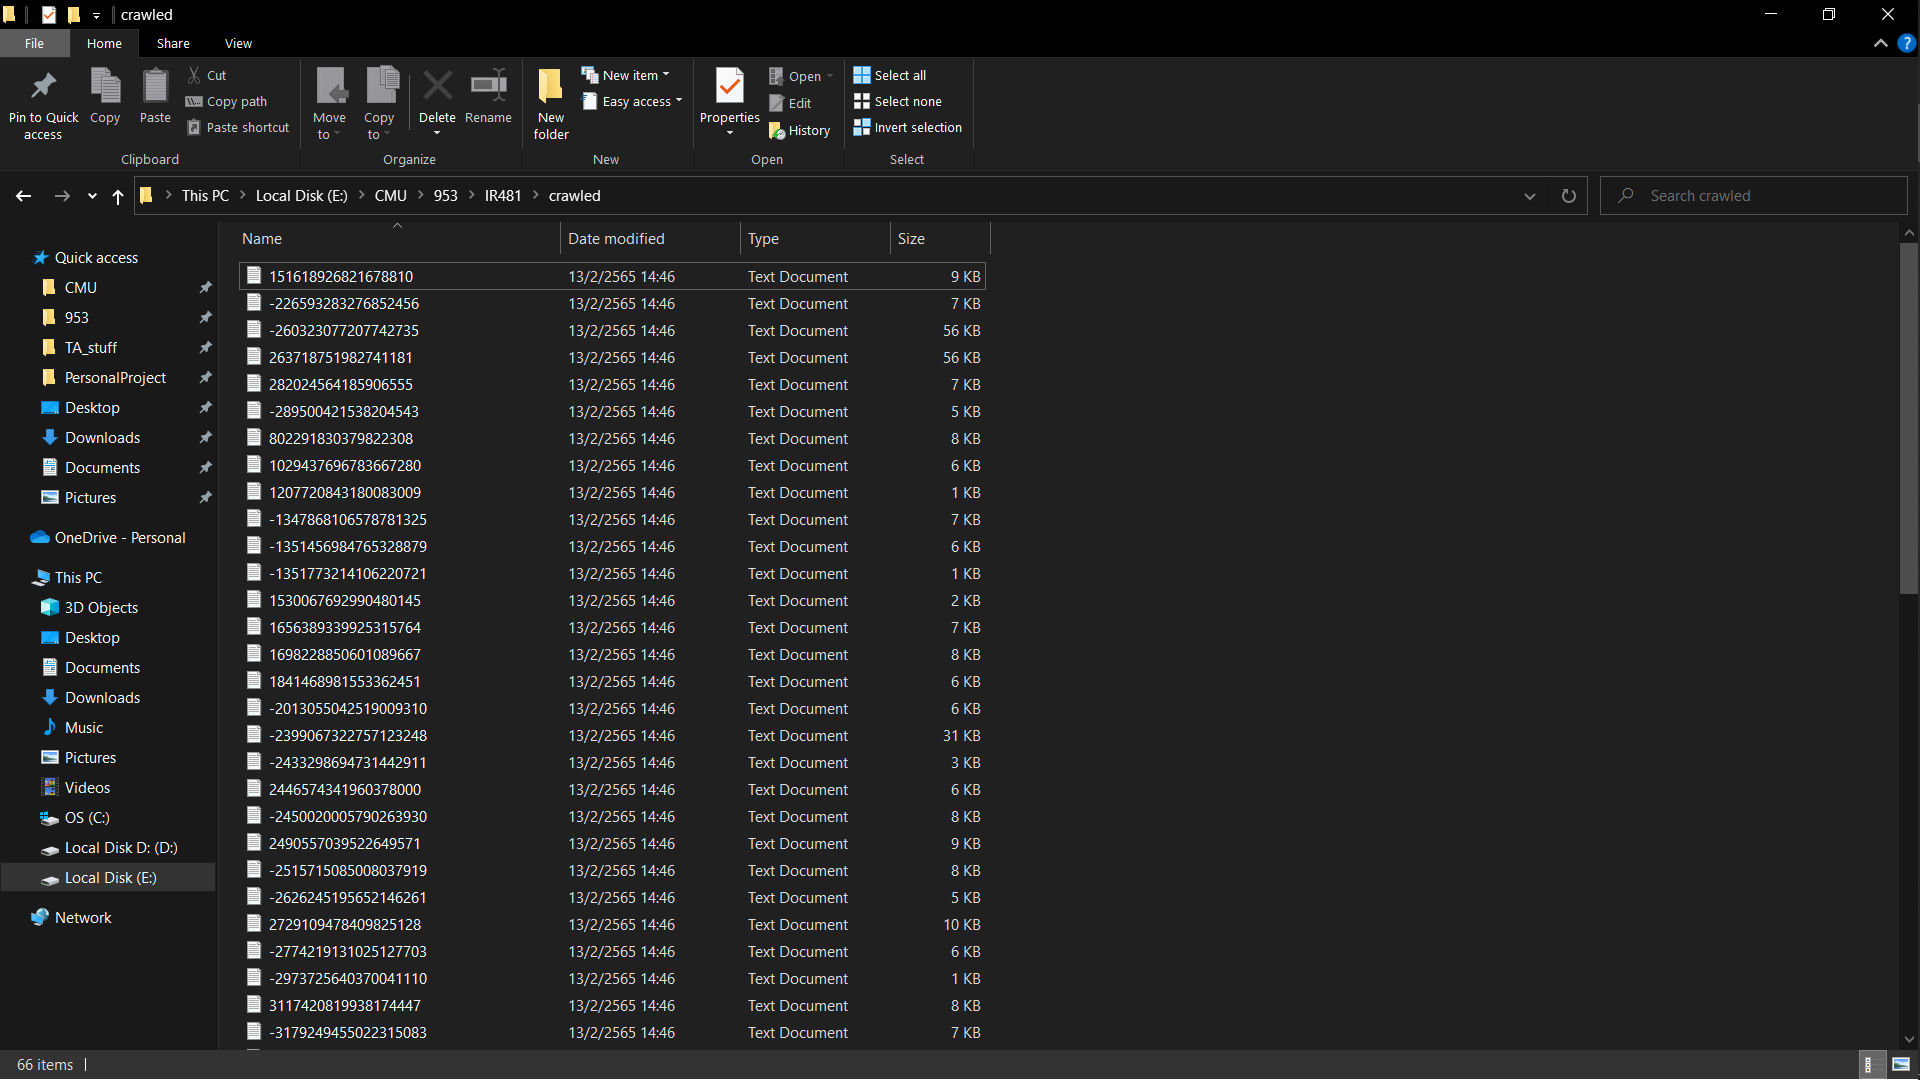